In [2]:
# Author and date
import datetime, getpass
user = getpass.getuser()
print(user, datetime.datetime.today())

ubuntu 2020-04-26 20:25:27.475586


In [3]:
user = 'cinni'  # the system user was different from database user

In [4]:
%matplotlib inline

In [5]:
import datajoint as dj
schema = dj.schema(f'{user}_university')
schema.spawn_missing_classes()

Connecting cinni@db.data-science-ust.net:3306


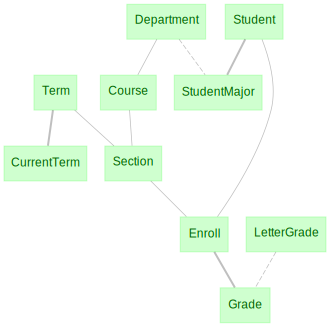

In [6]:
dj.Diagram(schema)

# Generate fake data

In [7]:
# Cleanup from previous run
Department.delete()
Student.delete()
LetterGrade.delete()
Term.delete()

About to delete:
`cinni_university`.`enroll`: 20878 items
`cinni_university`.`section`: 2575 items
`cinni_university`.`course`: 45 items
`cinni_university`.`department`: 4 items
Proceed? [yes, No]: 
Cancelled deletes.
About to delete:
`cinni_university`.`enroll`: 20878 items
`cinni_university`.`student`: 1500 items
Proceed? [yes, No]: 
Cancelled deletes.
About to delete:
Nothing to delete
About to delete:
`cinni_university`.`enroll`: 20878 items
`cinni_university`.`section`: 2575 items
`cinni_university`.`current_term`: 1 items
`cinni_university`.`term`: 60 items
Proceed? [yes, No]: 
Cancelled deletes.


In [8]:
Term.delete()

About to delete:
`cinni_university`.`enroll`: 20878 items
`cinni_university`.`section`: 2575 items
`cinni_university`.`current_term`: 1 items
`cinni_university`.`term`: 60 items
Proceed? [yes, No]: yes
Committed.


In [9]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

In [10]:
fake.name_female()

'Teresa Luna'

## Students

In [11]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [12]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(1000,2500), yield_students()))

DuplicateError: ("Duplicate entry '1000' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [13]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1000,Kimberly,Thomas,F,1991-07-26,851 Beverly Neck Suite 918,West Elizabethmouth,NY,43733,9263148671
1001,Kelsey,Ortiz,F,1987-04-12,969 Brady Prairie,North Carl,NC,45561,740.419.5209
1002,Alan,Vasquez,M,1987-08-07,410 Burton Throughway Suite 758,Coopershire,MS,09722,001-838-846-9491
1003,Lisa,Carey,F,2002-03-29,21881 Maria Branch,Port Christopher,WA,13740,815.277.7140
1004,Robert,Davis,M,1990-03-06,5030 Robert Square Apt. 532,North Curtischester,CA,50038,(974)377-3167x458
1005,Veronica,Scott,F,2002-09-23,6735 Monica Streets Suite 378,Lake Gregoryberg,DE,91515,(400)133-1762
1006,Elizabeth,Jones,F,1999-05-28,65233 Theresa Route Apt. 069,Annview,OK,17712,155.836.9246
1007,David,Thornton,M,1998-01-27,32239 Wayne Islands Apt. 659,Reedton,HI,11377,013-814-2923
1008,Paul,Miller,M,1988-03-26,5872 Sandra Freeway Apt. 797,South Richardport,ME,19277,+1-462-203-5730x917
1009,Patrick,Anderson,M,2003-12-22,8253 Brandy Junctions Suite 004,Laurenville,ME,78172,(608)525-6788x99495


## Departments, majors, and courses

In [14]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

DuplicateError: ("Duplicate entry 'CS' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [15]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [16]:
 StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
1000,BIOL,2019-01-04
1001,CS,2018-01-08
1002,CS,2006-05-23
1004,BIOL,2016-12-03
1005,CS,2017-01-27
1006,PHYS,2014-07-27
1007,BIOL,2006-07-30
1008,MATH,2000-12-31
1009,BIOL,2002-01-08
1010,CS,2011-06-24


In [17]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

DuplicateError: ("Duplicate entry 'BIOL-1006' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

## Terms and course sections

In [18]:
Course()

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010","course_name e.g. ""Neurobiology of Sensation and Movement.""",credits number of credits earned by completing the course
BIOL,1006,World of Dinosaurs,3.0
BIOL,1010,Biology in the 21st Century,3.0
BIOL,1030,Human Biology,3.0
BIOL,1210,Principles of Biology,4.0
BIOL,2010,Evolution & Diversity of Life,3.0
BIOL,2020,Principles of Cell Biology,3.0
BIOL,2021,Principles of Cell Science,4.0
BIOL,2030,Principles of Genetics,3.0
BIOL,2210,Human Genetics,3.0
BIOL,2325,Human Anatomy,4.0


In [19]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [20]:
Section()

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,auditorium
BIOL,1006,2000,Spring,a,C28
BIOL,1006,2000,Fall,a,D28
BIOL,1006,2001,Fall,a,A14
BIOL,1006,2001,Fall,b,F90
BIOL,1006,2001,Fall,c,E39
BIOL,1006,2001,Fall,d,B45
BIOL,1006,2002,Summer,a,B3
BIOL,1006,2002,Summer,b,E87
BIOL,1006,2002,Fall,a,B76
BIOL,1006,2002,Fall,b,A58


In [21]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

## Enrollment and grades

In [23]:
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

 46%|████▋     | 697/1500 [02:20<02:42,  4.95it/s]


KeyboardInterrupt: 

In [ ]:
Student() & 'sex="F"' & 'date_of_birth> "2000-01-01"'

In [ ]:
Enroll()

In [28]:
from matplotlib import pyplot as plt

In [29]:
q = Student.aggr(Enroll, n='count(*)').fetch('n')

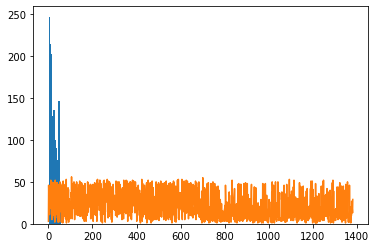

In [31]:
plt.hist(q)
plt.plot(q)
#plt.xlabel('# enrolled sections')
#plt.ylabel('# students')

In [51]:
# assign random grades
grades = LetterGrade.fetch('grade')

In [ ]:
grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

In [ ]:
Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [ ]:
Grade()

In [ ]:
# grade distribution 
dj.U('grade').aggr(Grade, n='count(*)')